In [1]:
!pip install  numpy transformer_lens

from transformer_lens import HookedTransformer, utils
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

model_gpt = HookedTransformer.from_pretrained("gpt2-small")




`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
logits = model_gpt("Famous computer scientist Alan")
# The logit dimensions are: [batch, position, vocab]
next_token_logits = logits[0, -1]
next_token_prediction = next_token_logits.argmax()
next_word_prediction = model_gpt.tokenizer.decode(next_token_prediction)
print(next_word_prediction)


 Turing


In [3]:
logits, cache = model_gpt.run_with_cache("Famous computer scientist Alan")
for key, value in cache.items():
    print(key, value.shape)

hook_embed torch.Size([1, 6, 768])
hook_pos_embed torch.Size([1, 6, 768])
blocks.0.hook_resid_pre torch.Size([1, 6, 768])
blocks.0.ln1.hook_scale torch.Size([1, 6, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 6, 768])
blocks.0.attn.hook_q torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_k torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_v torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 12, 6, 6])
blocks.0.attn.hook_pattern torch.Size([1, 12, 6, 6])
blocks.0.attn.hook_z torch.Size([1, 6, 12, 64])
blocks.0.hook_attn_out torch.Size([1, 6, 768])
blocks.0.hook_resid_mid torch.Size([1, 6, 768])
blocks.0.ln2.hook_scale torch.Size([1, 6, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 6, 768])
blocks.0.mlp.hook_pre torch.Size([1, 6, 3072])
blocks.0.mlp.hook_post torch.Size([1, 6, 3072])
blocks.0.hook_mlp_out torch.Size([1, 6, 768])
blocks.0.hook_resid_post torch.Size([1, 6, 768])
blocks.1.hook_resid_pre torch.Size([1, 6, 768])
blocks.1.ln1.hook_scale torch.Size([1, 6, 1])

In [4]:
utils.test_prompt("Her name was Alex Hart. Tomorrow at lunch time Alex",
                  " Hart", model_gpt)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Hart', '.', ' Tomorrow', ' at', ' lunch', ' time', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 3        Logit: 14.29 Prob:  7.35% Token: | Hart|

Top 0th token. Logit: 15.64 Prob: 28.38% Token: | will|
Top 1th token. Logit: 14.47 Prob:  8.79% Token: | would|
Top 2th token. Logit: 14.34 Prob:  7.74% Token: | was|
Top 3th token. Logit: 14.29 Prob:  7.35% Token: | Hart|
Top 4th token. Logit: 14.18 Prob:  6.54% Token: | and|
Top 5th token. Logit: 14.09 Prob:  6.00% Token: | is|
Top 6th token. Logit: 13.51 Prob:  3.38% Token: |'s|
Top 7th token. Logit: 13.23 Prob:  2.53% Token: |,|
Top 8th token. Logit: 12.73 Prob:  1.55% Token: | had|
Top 9th token. Logit: 12.00 Prob:  0.74% Token: | has|


Ranks of the answer tokens: [(' Hart', 3)]

In [5]:
_, corrupt_cache = model_gpt.run_with_cache("Her name was Alex Carroll. Tomorrow at lunch time Alex")

In [6]:
def patch_residual_stream(activations, hook, layer="blocks.6.hook_resid_post", pos=5):
   # The residual stream dimensions are [batch, position, d_embed]
   activations[:, pos, :] = corrupt_cache[layer][:, pos, :]
   return activations

# add_hook takes 2 args: Where to insert the patch,
# and the function providing the updated activations
model_gpt.add_hook("blocks.6.hook_resid_post", patch_residual_stream)

Clean prob of ' Hart': 0.000
Corrupt prob of ' Hart': 0.000


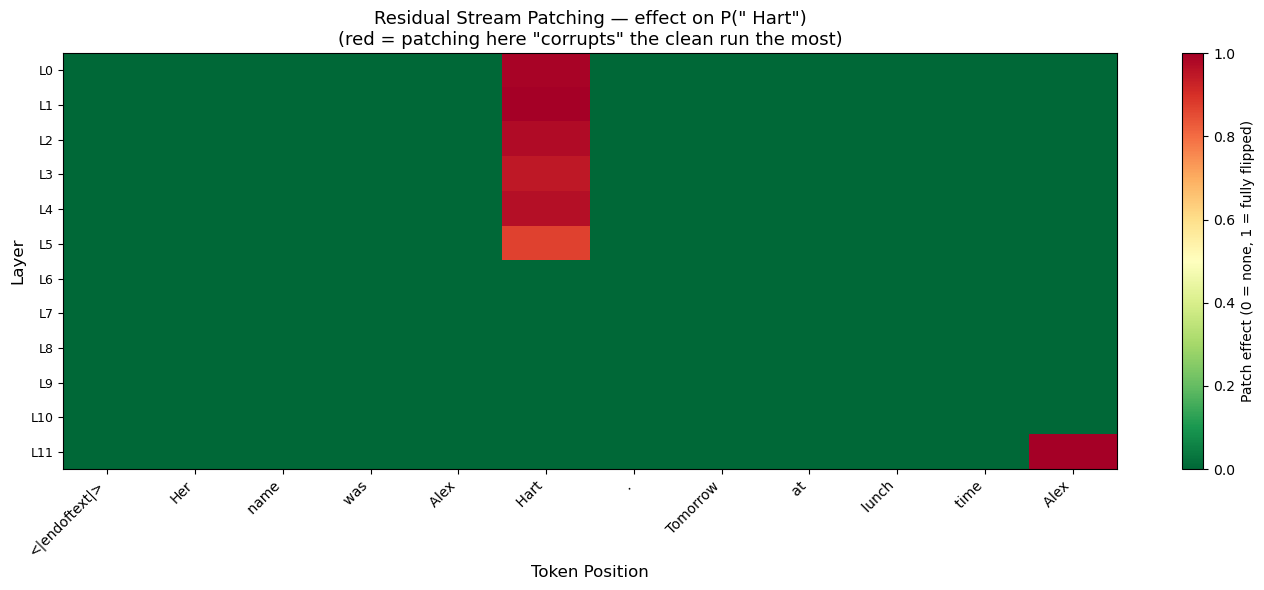

Saved to patching_heatmap.png


In [7]:


# ── Setup ────────────────────────────────────────────────────────────────────

CLEAN_PROMPT   = "Her name was Alex Hart. Tomorrow at lunch time Alex"
CORRUPT_PROMPT = "Her name was Alex Carroll. Tomorrow at lunch time Alex"
TARGET_TOKEN   = " Hart"

# Run both prompts and cache activations
clean_logits, clean_cache     = model_gpt.run_with_cache(CLEAN_PROMPT)
corrupt_logits, corrupt_cache = model_gpt.run_with_cache(CORRUPT_PROMPT)

# Get the index of the target token (" Hart") in the vocabulary
target_token_id = model_gpt.to_single_token(TARGET_TOKEN)

# Helper: get the probability of " Hart" given a set of logits
def get_target_prob(logits):
    probs = torch.softmax(logits[0, -1], dim=-1)
    return probs[target_token_id].item()

# Baseline: how likely is " Hart" in the clean run (should be high)
clean_prob = get_target_prob(clean_logits)
print(f"Clean prob of '{TARGET_TOKEN}': {clean_prob:.3f}")

# Corrupted baseline: how likely is " Hart" in the corrupt run (should be low)
corrupt_prob = get_target_prob(corrupt_logits)
print(f"Corrupt prob of '{TARGET_TOKEN}': {corrupt_prob:.3f}")

# ── Grid Search ──────────────────────────────────────────────────────────────

n_layers    = model_gpt.cfg.n_layers          # 12 for GPT-2 small
n_positions = clean_logits.shape[1]           # number of tokens in the prompt

# We'll store how much each patch *recovers* the clean probability.
# 0 = no effect (stays corrupt), 1 = full recovery (back to clean)
results = np.zeros((n_layers, n_positions))

for layer in range(n_layers):
    hook_name = f"blocks.{layer}.hook_resid_post"

    for pos in range(n_positions):

        # Build a patch that swaps position `pos` at `layer`
        def make_patch(hook_name=hook_name, pos=pos):
            def patch_fn(activations, hook):
                activations[:, pos, :] = corrupt_cache[hook_name][:, pos, :]
                return activations
            return patch_fn

        # Run the clean prompt with this single patch applied
        model_gpt.reset_hooks()
        patched_logits = model_gpt.run_with_hooks(
            CLEAN_PROMPT,
            fwd_hooks=[(hook_name, make_patch())]
        )

        patched_prob = get_target_prob(patched_logits)

        # Normalise: how much did we move from clean → corrupt?
        # 1 = fully flipped to corrupt, 0 = no change
        effect = (clean_prob - patched_prob) / (clean_prob - corrupt_prob + 1e-8)
        results[layer, pos] = np.clip(effect, 0, 1)

model_gpt.reset_hooks()

# ── Plot ─────────────────────────────────────────────────────────────────────

# Token labels for the x-axis
tokens = model_gpt.to_str_tokens(CLEAN_PROMPT)

fig, ax = plt.subplots(figsize=(14, 6))

im = ax.imshow(
    results,
    aspect="auto",
    cmap="RdYlGn_r",   # green = no effect, red = big effect
    vmin=0, vmax=1
)

# Axes labels
ax.set_xlabel("Token Position", fontsize=12)
ax.set_ylabel("Layer", fontsize=12)
ax.set_title(
    f'Residual Stream Patching — effect on P("{TARGET_TOKEN}")\n'
    f'(red = patching here "corrupts" the clean run the most)',
    fontsize=13
)

ax.set_xticks(range(n_positions))
ax.set_xticklabels(tokens, rotation=45, ha="right", fontsize=10)
ax.set_yticks(range(n_layers))
ax.set_yticklabels([f"L{i}" for i in range(n_layers)], fontsize=9)

plt.colorbar(im, ax=ax, label="Patch effect (0 = none, 1 = fully flipped)")
plt.tight_layout()
plt.savefig("patching_heatmap.png", dpi=150)
plt.show()

print("Saved to patching_heatmap.png")

# Method 2: 

In [20]:
import torch
from transformer_lens import HookedTransformer
from functools import partial


model_2l = HookedTransformer.from_pretrained("gelu-2l")
model_2l.cfg.use_attn_result = True


config.json: 0.00B [00:00, ?B/s]

./model_final.pth:   0%|          | 0.00/227M [00:00<?, ?B/s]

RuntimeError: MPS backend out of memory (MPS allocated: 18.10 GiB, other allocations: 656.00 KiB, max allowed: 18.13 GiB). Tried to allocate 94.26 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [16]:


clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
corrupt_prompt = "Her name was Alex Carroll. Tomorrow at lunch time Alex"

clean_tokens = model_6l.to_tokens(clean_prompt)
corrupt_tokens = model_6l.to_tokens(corrupt_prompt)

_, corrupt_cache_6l = model_6l.run_with_cache(corrupt_tokens)

def patch_residual_stream(activations, hook, layer, pos):
    activations[:, pos, :] = corrupt_cache_6l[layer][:, pos, :]
    return activations

layers = ["blocks.0.hook_resid_pre"] + \
         [f"blocks.{i}.hook_resid_post" for i in range(model_6l.cfg.n_layers)]

n_layers = len(layers)
n_pos = clean_tokens.shape[1]

clean_answer_index = model_6l.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model_6l.tokenizer.encode(" Carroll")[0]

device = model_6l.cfg.device
patching_effect = torch.zeros(n_layers, n_pos, device=device)

for l, layer in enumerate(layers):
    print("Patching layer", l)
    for pos in range(n_pos):
        fwd_hooks = [(layer, partial(patch_residual_stream, layer=layer, pos=pos))]
        prediction_logits = model_6l.run_with_hooks(
            clean_tokens,
            fwd_hooks=fwd_hooks
        )[0, -1]

        patching_effect[l, pos] = (
            prediction_logits[clean_answer_index]
            - prediction_logits[corrupt_answer_index]
        )

torch.cuda.empty_cache()

RuntimeError: MPS backend out of memory (MPS allocated: 18.10 GiB, other allocations: 26.64 MiB, max allowed: 18.13 GiB). Tried to allocate 27.00 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
# Plot
token_labels = [f"(pos {i:2}) {t}" for i, t in enumerate(clean_tokens)]
head_labels = [f"(head {i:2})" for i in range(n_heads)]
layer_labels = [f"(layer {i:2})" for i in range(n_layers)]

imshow(patching_effect, xticks=head_labels, yticks=layer_labels, xlabel="head", ylabel="layer",
       zlabel="Logit difference", title="Patching with 1st occurrence of first name", width=600, height=380)
